## Recurrent Neural Network (RNN)

Steps of RNN:

1.Import Libraries

2.Prepare Dataset

3.Create RNN Model
    
    hidden layer dimension is 100
    
    number of hidden layer is 1

4.Instantiate Model

5.Instantiate Loss

    Cross entropy loss

    It also has softmax(logistic function) in it.

6.Instantiate Optimizer

    SGD Optimizer

7.Traning the Model

8.Prediction

In [1]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset  #Veriyi pytorch'da train edebilir hale getirmek için bu kütüphaneler import edilmiştir.

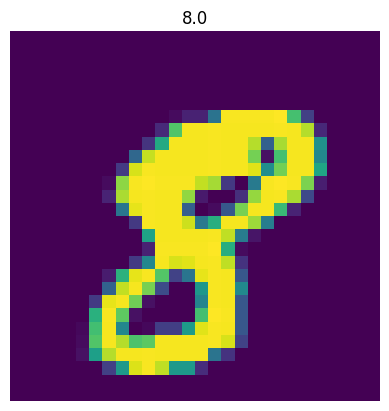

In [2]:
# Prepare Dataset
# load data
train = pd.read_csv(r"C:\Users\raziy\OneDrive\Masaüstü\Caner hocanın attıkları\KURS ÇALIŞMALARIM\Python ve Derin Öğrenme Pytorch ile Derin Öğrenme (5.3)\6-RecurrentNeuralNetworks\train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values  #class değerleri yani label'lar targets_numpy değişkenine atanmıştır.
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
#numpy array'leri torch tensörlerine çevrilmiştir:
featuresTrain = torch.from_numpy(features_train) 
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
#numpy array'leri torch tensörlerine çevrilmiştir:
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain) #Tensor veri setine çevrilmiştir.
test = TensorDataset(featuresTest,targetsTest)

# data loader
#Train ve testin eğitilebilir olması için yani pytorch ile kullanılabilir olması için DataLoader isimli metodun içerisine konur.
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

Kullanılan veri seti 0'dan 9'a kadar el yazısı ile yazılan rakamlara ait görselleri içermektedir.

In [3]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    #Birbirine bağlama işlemi için forward metodu yazılmıştır.
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
 
Bu satırda, 1.parametre input'ların size bilgisidir. 2.parametre hidden layer'ların size bilgisidir. 3.parametre kaç tane layer olacağı bilgisidir.

In [7]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 0.09166377782821655  Accuracy: 96.51190185546875 %
Iteration: 1000  Loss: 0.05945394188165665  Accuracy: 96.30952453613281 %
Iteration: 1500  Loss: 0.06395179033279419  Accuracy: 94.72618865966797 %
Iteration: 2000  Loss: 0.09486214816570282  Accuracy: 97.20237731933594 %
Iteration: 2500  Loss: 0.06732679158449173  Accuracy: 96.94047546386719 %
Iteration: 3000  Loss: 0.053724005818367004  Accuracy: 95.94047546386719 %
Iteration: 3500  Loss: 0.23041602969169617  Accuracy: 95.95237731933594 %
Iteration: 4000  Loss: 0.01261448860168457  Accuracy: 96.91666412353516 %
Iteration: 4500  Loss: 0.09812218695878983  Accuracy: 97.0952377319336 %
Iteration: 5000  Loss: 0.01965576596558094  Accuracy: 97.20237731933594 %
Iteration: 5500  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 6000  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 6500  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 7000  Loss: nan  Accuracy: 9.714285850524902 %
Iteration: 7500  Loss: nan  A

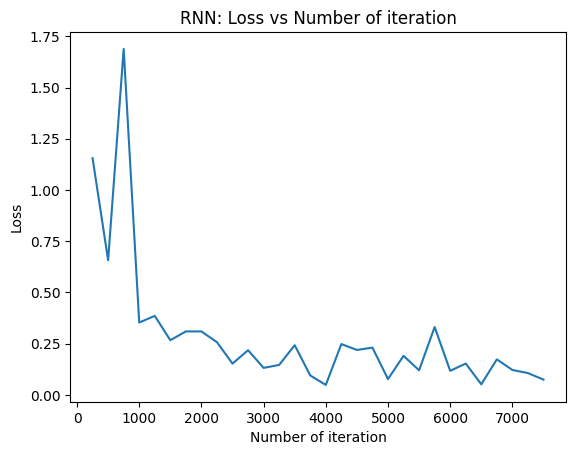

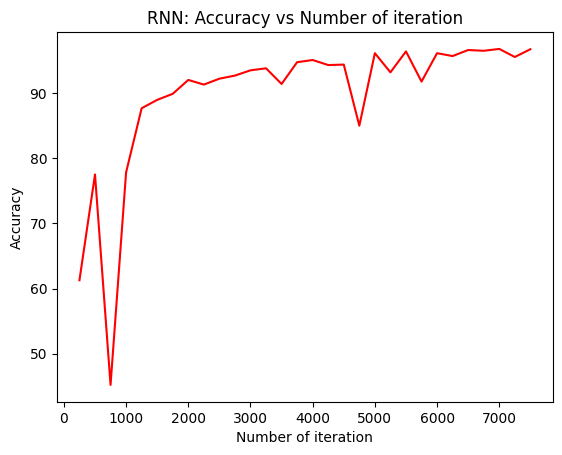

In [6]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

Çıktıda görüldüğü üzere loss azaldıkça accuracy artmaktadır.